Imports for the code below

In [18]:
import matplotlib.pyplot as plt
import numpy as np

In [19]:
class Board:
    def __init__(self, size: int = 8) -> None:
        self.size = size
        self.sate = np.zeros(size, dtype=int)
        
    def __str__(self) -> str:
        return str(self.sate)
    
    def __repr__(self) -> str:
        return str(self.sate)
    
    def __eq__(self, __value: object) -> bool:
        return isinstance(__value, Board) and self.sate == __value.sate
    
    def __hash__(self) -> int:
        return hash(str(self.sate))
    
    def clone(self) -> object:
        board = Board(self.size)
        board.sate = self.sate.copy()
        return board
    
    def shuffle(self) -> None:
        np.random.shuffle(self.sate)
    
    def put_queen(self, row: int, col: int) -> None:
        self.sate[row] = col
        
    def render(self):
        board = np.zeros((self.size, self.size))

        board[::2, ::2] = 1
        board[1::2, 1::2] = 1

        plt.figure(figsize=(self.size, self.size))
        plt.imshow(board, cmap='gray')

        for row, col in enumerate(self.sate):
            plt.text(col, row, '♛', fontsize=36, ha='center', va='center', color='blue')

        plt.xticks([])
        plt.yticks([])
        plt.show()

#### Hill Climbing

In [20]:
from typing import Callable, Iterable

def hill_climbing(state: object, next_states: Callable[[object], Iterable[object]], 
                  h: Callable[[object], float], max_budget: int = 1000) -> object:
    current = state
    while max_budget >= 0:
        neighbours = next_states(current)
        best_neighbour = min(neighbours, key=h)
        if best_neighbour == None or h(best_neighbour) > h(current):
            return current
        current = best_neighbour
        max_budget -= 1

    return current
        
def hill_climbing_random_restart(state: object, shuffle: Callable[[object], object], next_states: Callable[[object], Iterable[object]], 
                                 h: Callable[[object], float], max_budget: int = 1000, max_restart: int = 100) -> object:
    best_result = state
    while max_restart > 0:
        result = hill_climbing(state, next_states, h, max_budget)
        if h(result) < h(best_result):
            best_result = result
        max_restart -= 1
        state = shuffle(state)

    return best_result

In [21]:
import matplotlib.pyplot as plt

def next_states(board: Board) -> Iterable[Board]:
    boards = []
    row = np.random.randint(board.size)
    for col in range(board.size):
        if board.sate[row] != col:
            new_board = board.clone()
            new_board.put_queen(row, col)
            boards.append(new_board)
    return boards

def shuffle(board: Board) -> Board:
    board.shuffle()
    return board
                
def count_attacking_pairs(board: Board) -> int:
    count = 0
    for row1 in range(board.size):
        for row2 in range(row1 + 1, board.size):
            col1, col2 = board.sate[row1], board.sate[row2]
            if col1 == col2 or abs(row1 - row2) == abs(col1 - col2):
                count += 1
    return count


#### Simulated annealing

In [22]:
import math
import random
def simulated_annealing(state: object, next_states: Callable[[object], Iterable[object]], h: Callable[[object], float],
                        temperature: float = 1.0, final_temperature: float = 0.1, cooling_rate: float = 0.01) -> object:
    current = state
    while temperature > final_temperature:
        neighbours = next_states(current)
        next_state = random.choice(neighbours)
        current_energy = h(current)
        next_energy = h(next_state)
        energy_diff = next_energy - current_energy
        if energy_diff < 0 or math.exp(-energy_diff / temperature) > random.random():
            current = next_state
        temperature *= 1 - cooling_rate
    return current

#### Statistics

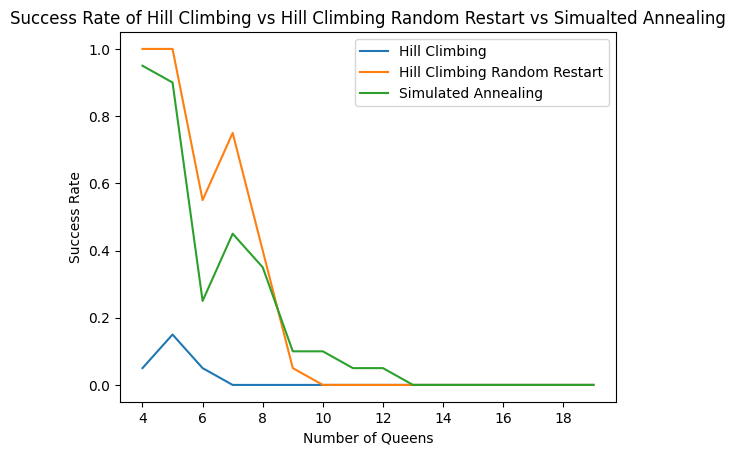

In [24]:
success_rates_hill_climbing = []
success_rates_hill_climbing_random_restart = []
success_rates_simulated_annealing = []

max_queens_count = 20
budget = 1000
retries = 20

for queens_count in range(4, max_queens_count):
    hill_climbing_success_count = 0
    hill_climbing_random_restart_success_count = 0
    simulated_annealing_success_count = 0
    
    for _ in range(retries):
        board = Board(queens_count)
        
        result = hill_climbing(board, next_states, count_attacking_pairs, budget)
        if count_attacking_pairs(result) == 0:
            hill_climbing_success_count += 1
        
        result = hill_climbing_random_restart(board, shuffle, next_states, count_attacking_pairs, budget, max_restart=100)
        if count_attacking_pairs(result) == 0:
            hill_climbing_random_restart_success_count += 1
        
        result = simulated_annealing(board, next_states, count_attacking_pairs, temperature=1.0, final_temperature=0.1, cooling_rate=0.01)
        if count_attacking_pairs(result) == 0:
            simulated_annealing_success_count += 1
    
    success_rate_hill_climbing = hill_climbing_success_count / retries
    success_rate_hill_climbing_random_restart = hill_climbing_random_restart_success_count / retries
    success_rate_simulated_annealing = simulated_annealing_success_count / retries

    success_rates_hill_climbing.append(success_rate_hill_climbing)
    success_rates_hill_climbing_random_restart.append(success_rate_hill_climbing_random_restart)
    success_rates_simulated_annealing.append(success_rate_simulated_annealing)

plt.plot(range(4, max_queens_count), success_rates_hill_climbing, label='Hill Climbing')
plt.plot(range(4, max_queens_count), success_rates_hill_climbing_random_restart, label='Hill Climbing Random Restart')
plt.plot(range(4, max_queens_count), success_rates_simulated_annealing, label='Simulated Annealing')
plt.xlabel('Number of Queens')
plt.ylabel('Success Rate')
plt.title('Success Rate of Hill Climbing vs Hill Climbing Random Restart vs Simualted Annealing')
plt.legend()
plt.show()